In [390]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import random
import os
import scipy.stats as stats

sns.set(style="white")

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨짐 방지

In [391]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
random_seed = 1106
set_random_seed(random_seed)

|컬럼 |내용|
|---|---|
sessionID | 세션 ID|
userID | 사용자 ID|
TARGET | 세션에서 발생한 총 조회수|
browser | 사용된 브라우저|
OS | 사용된 기기의 운영체제|
device | 사용된 기기|
new | 첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)|
quality | 세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)|
duration | 총 세션 시간 (단위: 초)|
bounced | 이탈 여부 (0: 이탈하지 않음, 1: 이탈함)|
transaction | 세션 내에서 발생의 거래의 수|
transaction_revenue | 총 거래 수익|
continent | 세션이 발생한 대륙|
subcontinent | 세션이 발생한 하위 대륙|
country | 세션이 발생한 국가|
traffic_source | 트래픽이 발생한 소스|
traffic_medium | 트래픽 소스의 매체|
keyword | 트래픽 소스의 키워드, 일반적으로 traffic_medium이 organic, cpc인 경우에 설정|
referral_path | traffic_medium이 referral인 경우 설정되는 경로|

## 데이터 로드 

In [392]:
df = pd.read_csv("D:/3차프로젝트/Weblog_Data/train.csv")
test = pd.read_csv("D:/3차프로젝트/Weblog_Data/test.csv")

df.head()

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000


## 데이터 EDA
keyword, referral_path 에서 결측치가 존재하는 것을 확인

In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [394]:
# duration,transaction_revenue 등 값의 범위가 매우 크기 때문에 데이터 스케일링을 진행할 필요성이 있어보인다. 
df.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,2.522890e+05
mean,3.592626,0.751955,3.816805,113.104253,0.493672,0.009033,9.061248e+05
std,5.509465,0.431879,11.091028,330.876019,0.499961,0.100938,2.127689e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


In [395]:
## userID에 중복이 존재한다. (나머지는 중복이 있지만, 카테고리.)
df.describe(include='object')

,sessionID,userID,browser,OS,device,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
count,252289,252289,252289,252289,252289,252289,252289,252289,252289,252289,114614,91182
unique,252289,206024,70,21,3,6,23,205,168,7,623,1578
top,SESSION_000000,USER_002675,Chrome,Windows,desktop,Americas,Northern America,United States,google,organic,Category8,Category1
freq,1,78,174395,88119,167133,126506,111945,104201,116007,107370,103584,18687


In [396]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sessionID            79786 non-null  object 
 1   userID               79786 non-null  object 
 2   browser              79786 non-null  object 
 3   OS                   79786 non-null  object 
 4   device               79786 non-null  object 
 5   new                  79786 non-null  int64  
 6   quality              79786 non-null  float64
 7   duration             79786 non-null  float64
 8   bounced              79786 non-null  int64  
 9   transaction          79786 non-null  float64
 10  transaction_revenue  79786 non-null  float64
 11  continent            79786 non-null  object 
 12  subcontinent         79786 non-null  object 
 13  country              79786 non-null  object 
 14  traffic_source       79786 non-null  object 
 15  traffic_medium       79786 non-null 

In [389]:
test.describe()

,new,quality,duration,bounced,transaction,transaction_revenue
count,79786.000000,79786.000000,79786.000000,79786.000000,79786.000000,7.978600e+04
mean,0.734515,3.967576,121.550635,0.496804,0.007909,9.552892e+05
std,0.441594,11.349192,349.168791,0.499993,0.095260,2.714007e+07
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000e+00
75%,1.000000,1.000000,75.000000,1.000000,0.000000,0.000000e+00
max,1.000000,98.000000,9316.000000,1.000000,7.000000,4.609835e+09


In [236]:
test.describe(include='object')

,sessionID,userID,browser,OS,device,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
count,79786,79786,79786,79786,79786,79786,79786,79786,79786,79786,36716,25895
unique,79786,64535,45,16,3,6,23,192,97,7,211,980
top,SESSION_252289,USER_108579,Chrome,Windows,desktop,Americas,Northern America,United States,google,organic,Category8,Category1
freq,1,58,57503,28383,54730,40429,35465,33179,37210,35894,34598,6050


### 결측치
keyword, referral_path 결측치가 너무 많아 삭제하기에는 데이터 손실로 인하여 대체법 생각

In [237]:
df.isnull().sum()

sessionID                   0
userID                      0
TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64

In [238]:
test.isnull().sum()

sessionID                  0
userID                     0
browser                    0
OS                         0
device                     0
new                        0
quality                    0
duration                   0
bounced                    0
transaction                0
transaction_revenue        0
continent                  0
subcontinent               0
country                    0
traffic_source             0
traffic_medium             0
keyword                43070
referral_path          53891
dtype: int64

### 중복 데이터 확인

In [239]:
df.duplicated().sum()

0

In [240]:
test.duplicated().sum()

0

### 데이터 시각화

#### 연속형 데이터 시각화

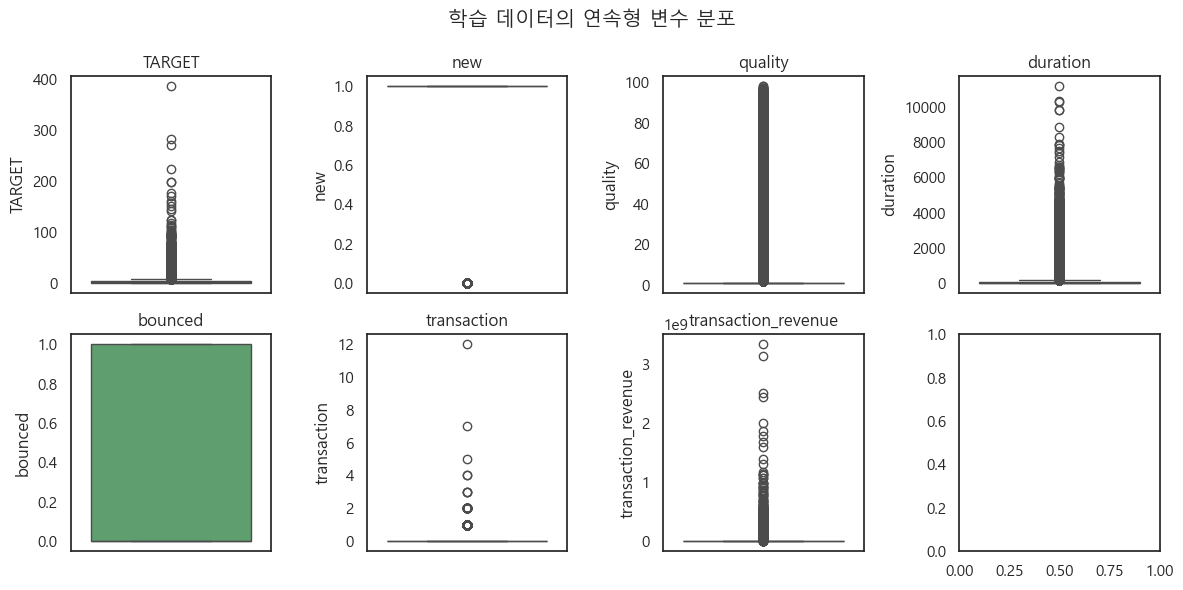

In [402]:
num_cols = df.describe().columns.tolist()
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

## 박스플롯
for idx, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[idx//4, idx%4], color='g') 
    axes[idx//4, idx%4].set_title(col)

plt.suptitle("학습 데이터의 연속형 변수 분포")
plt.tight_layout()
# plt.show()
plt.savefig("./연속형_전처리X.png")

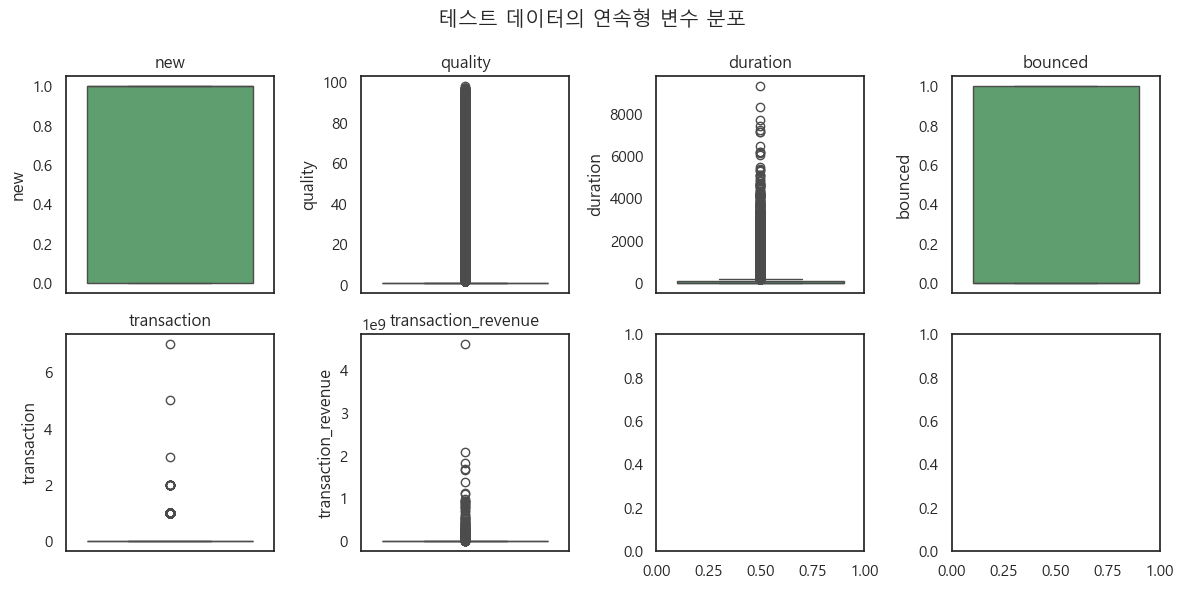

In [356]:
num_cols = test.describe().columns.tolist()
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

## 박스플롯
for idx, col in enumerate(num_cols):
    sns.boxplot(y=test[col], ax=axes[idx//4, idx%4], color='g') 
    axes[idx//4, idx%4].set_title(col)
    # plt.title("테스트 데이터")
    
plt.suptitle("테스트 데이터의 연속형 변수 분포")
plt.tight_layout()
# plt.show()
# plt.savefig("./테스트_연속형_전처리X.png")

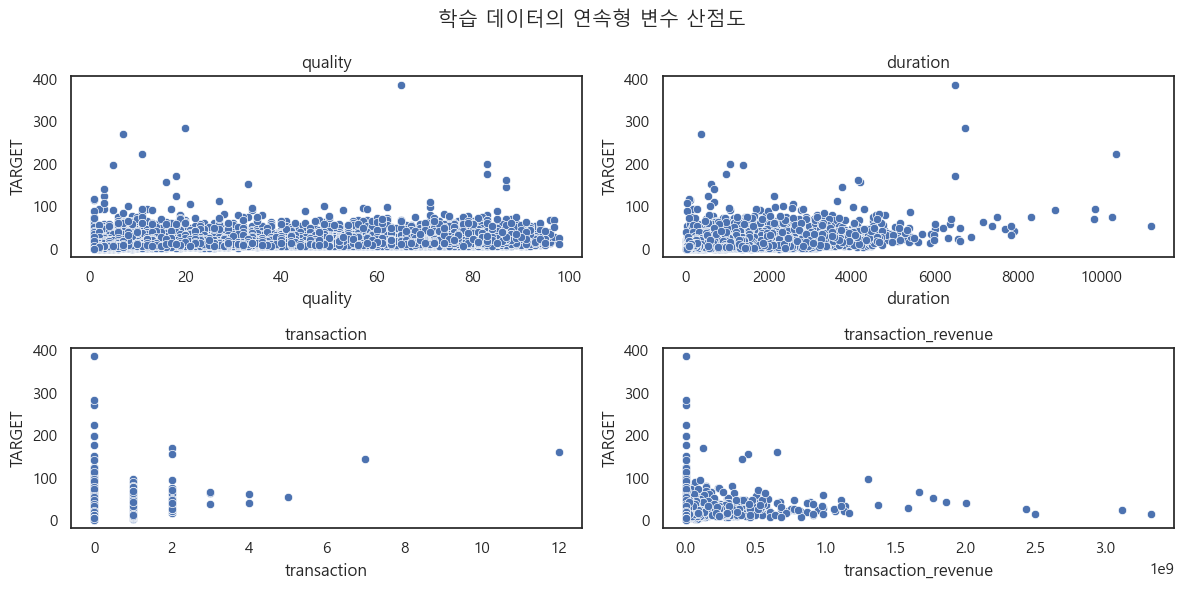

In [306]:
int_df = df[['quality', 'duration', 'transaction', 'transaction_revenue']]

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for idx, col in enumerate(int_df):
    sns.scatterplot(data=df, x=col, y='TARGET', ax=axes[idx//2, idx%2],)
    axes[idx//2, idx%2].set_title(col)
    
plt.xlabel(col)
plt.suptitle("학습 데이터의 연속형 변수 산점도")
plt.tight_layout()
plt.show()
# plt.savefig("./산점도 연속형_전처리X.png")

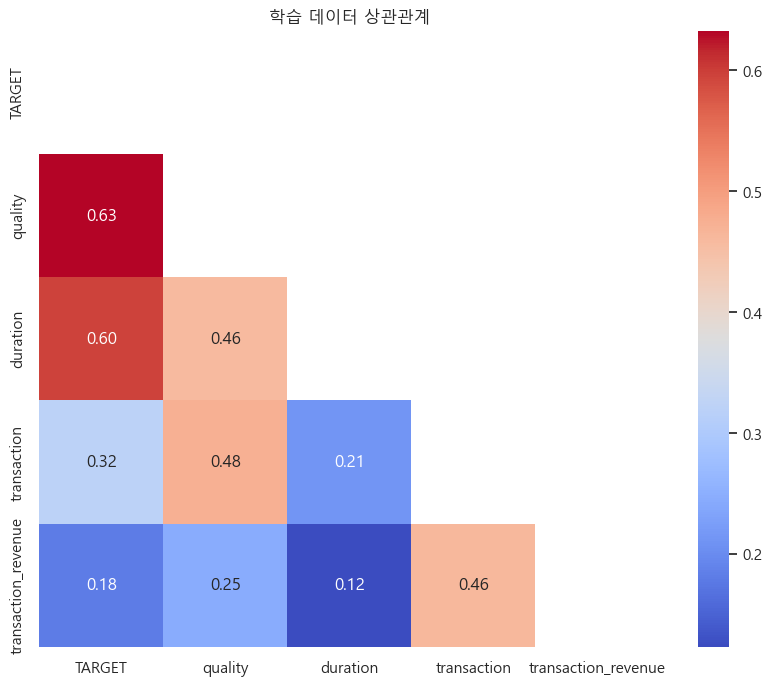

In [307]:
int_df = df[['TARGET', 'quality', 'duration', 'transaction', 'transaction_revenue']]

## 상관계수
correlation_matrix = int_df.corr()

## 대칭 결과이기 때문에 위쪽 부분 mask
mask = np.triu(np.ones_like(correlation_matrix))

selected_columns = int_df.columns.tolist()[1:]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap = 'coolwarm', mask = mask)
plt.title('학습 데이터 상관관계')
# plt.show()
# plt.savefig("./학습 데이터 상관관계_전처리X.png")

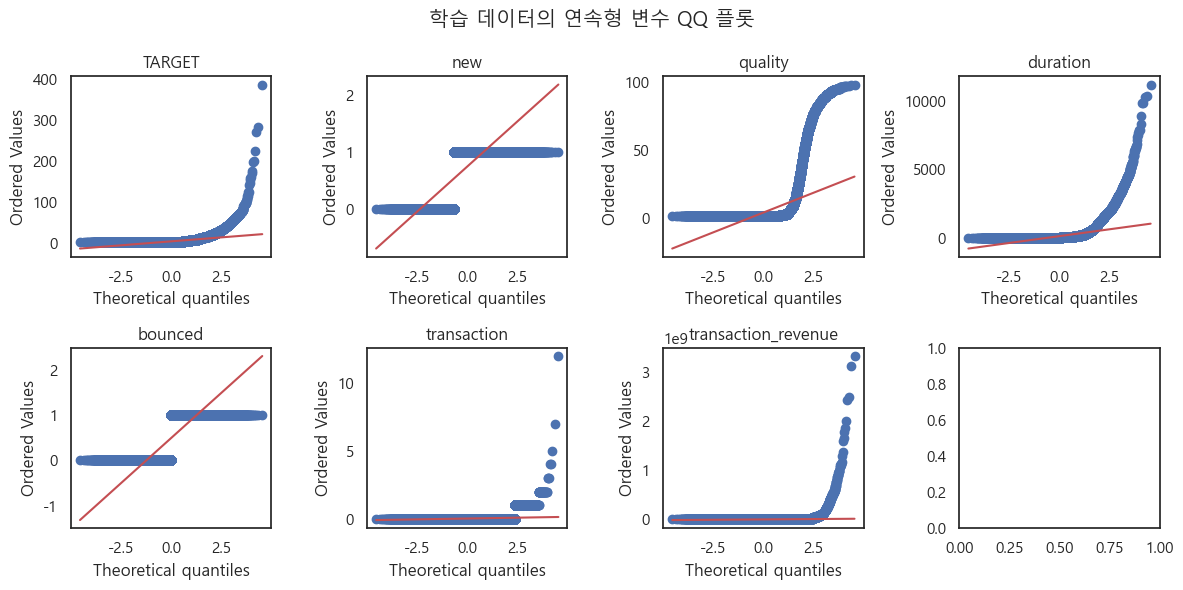

In [397]:
num_cols = df.describe().columns.tolist()
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# QQ 플롯
for idx, col in enumerate(num_cols):
    stats.probplot(df[col], dist="norm", plot=axes[idx//4, idx%4])
    axes[idx//4, idx%4].set_title(col)

plt.suptitle("학습 데이터의 연속형 변수 QQ 플롯")
plt.tight_layout()
plt.show()
# plt.savefig("./QQ 플롯_전처리X.png")

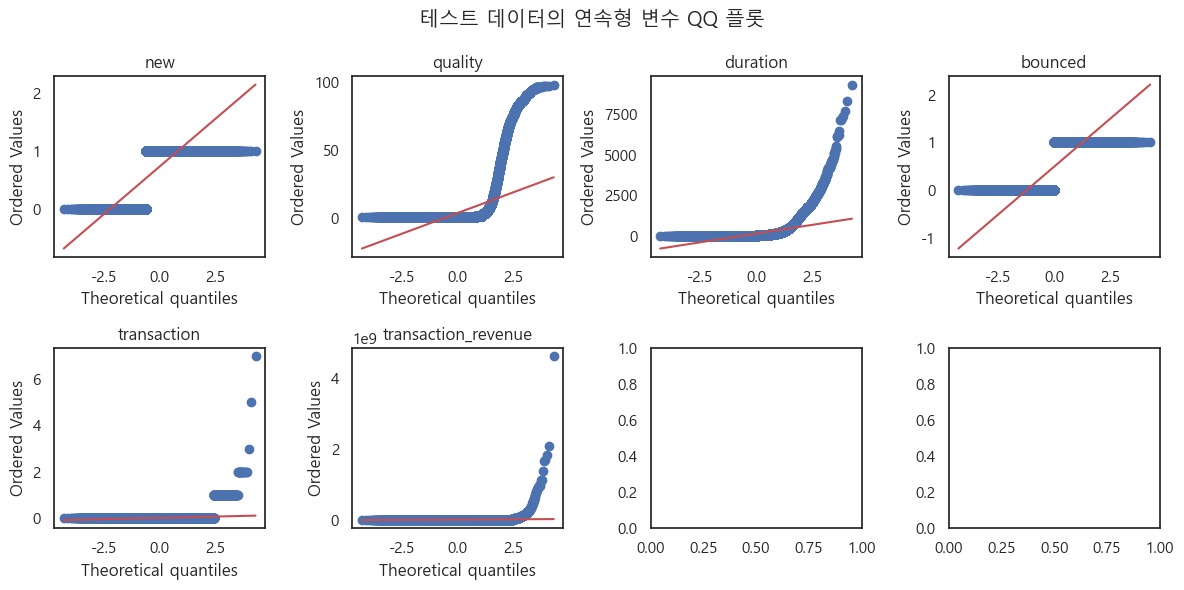

In [398]:
num_cols = test.describe().columns.tolist()
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# QQ 플롯
for idx, col in enumerate(num_cols):
    stats.probplot(test[col], dist="norm", plot=axes[idx//4, idx%4])
    axes[idx//4, idx%4].set_title(col)

plt.suptitle("테스트 데이터의 연속형 변수 QQ 플롯")
plt.tight_layout()
plt.show()
# plt.savefig("./테스트_QQ 플롯_전처리X.png")

#### 범주형 데이터 시각화

C:\Users\daesk\AppData\Local\Temp\ipykernel_19592\167010696.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


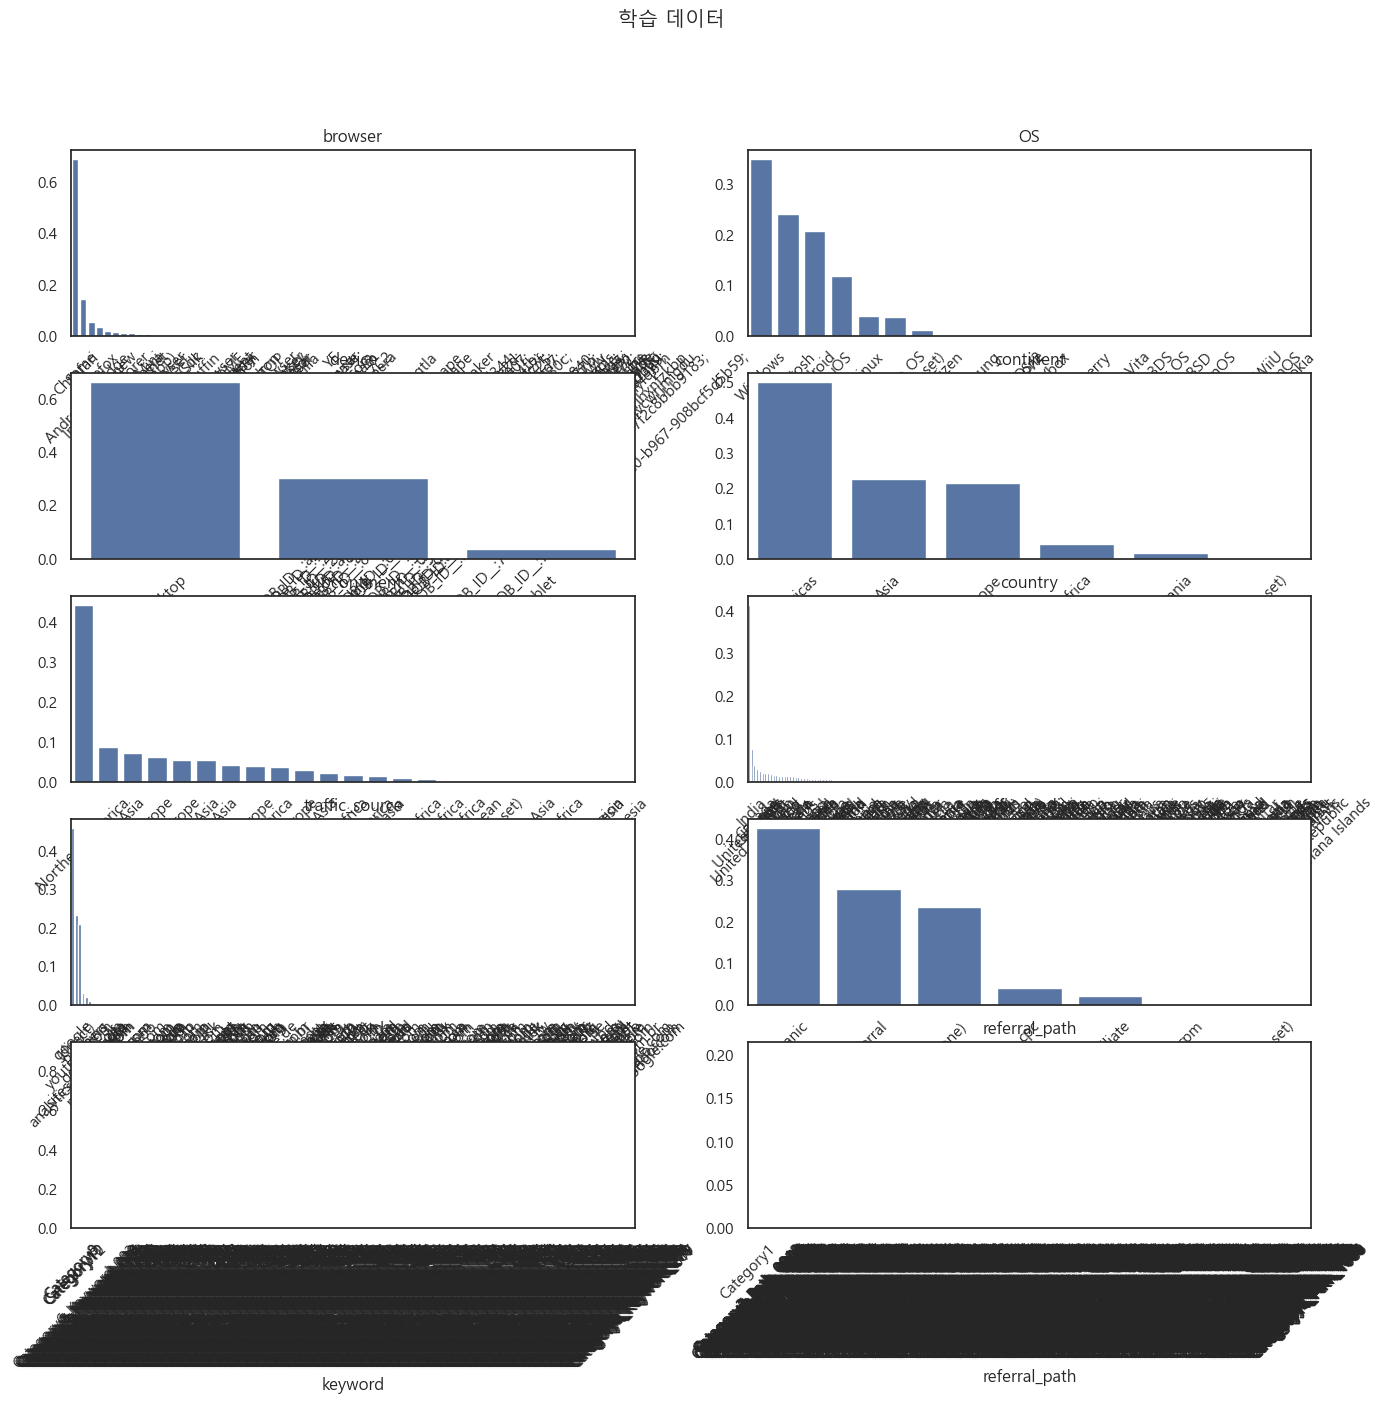

In [246]:
object_col = df.describe(include ='object').columns.tolist()[2:]
fig, axes = plt.subplots(5, 2, figsize=(16, 14))

for i, col in enumerate(object_col):  
    counts = df[col].value_counts(normalize=True).values
    categories = df[col].value_counts(normalize=True).index
    
    sns.barplot(x=categories, y=counts, ax=axes[i//2, i%2])
    axes[i//2, i%2].tick_params(axis='x', rotation=45)
    axes[i//2, i%2].set_title(col)

plt.suptitle("학습 데이터")
plt.tight_layout()
plt.show()
# plt.savefig("./범주형_전처리X.png")

C:\Users\daesk\AppData\Local\Temp\ipykernel_19592\1199056058.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


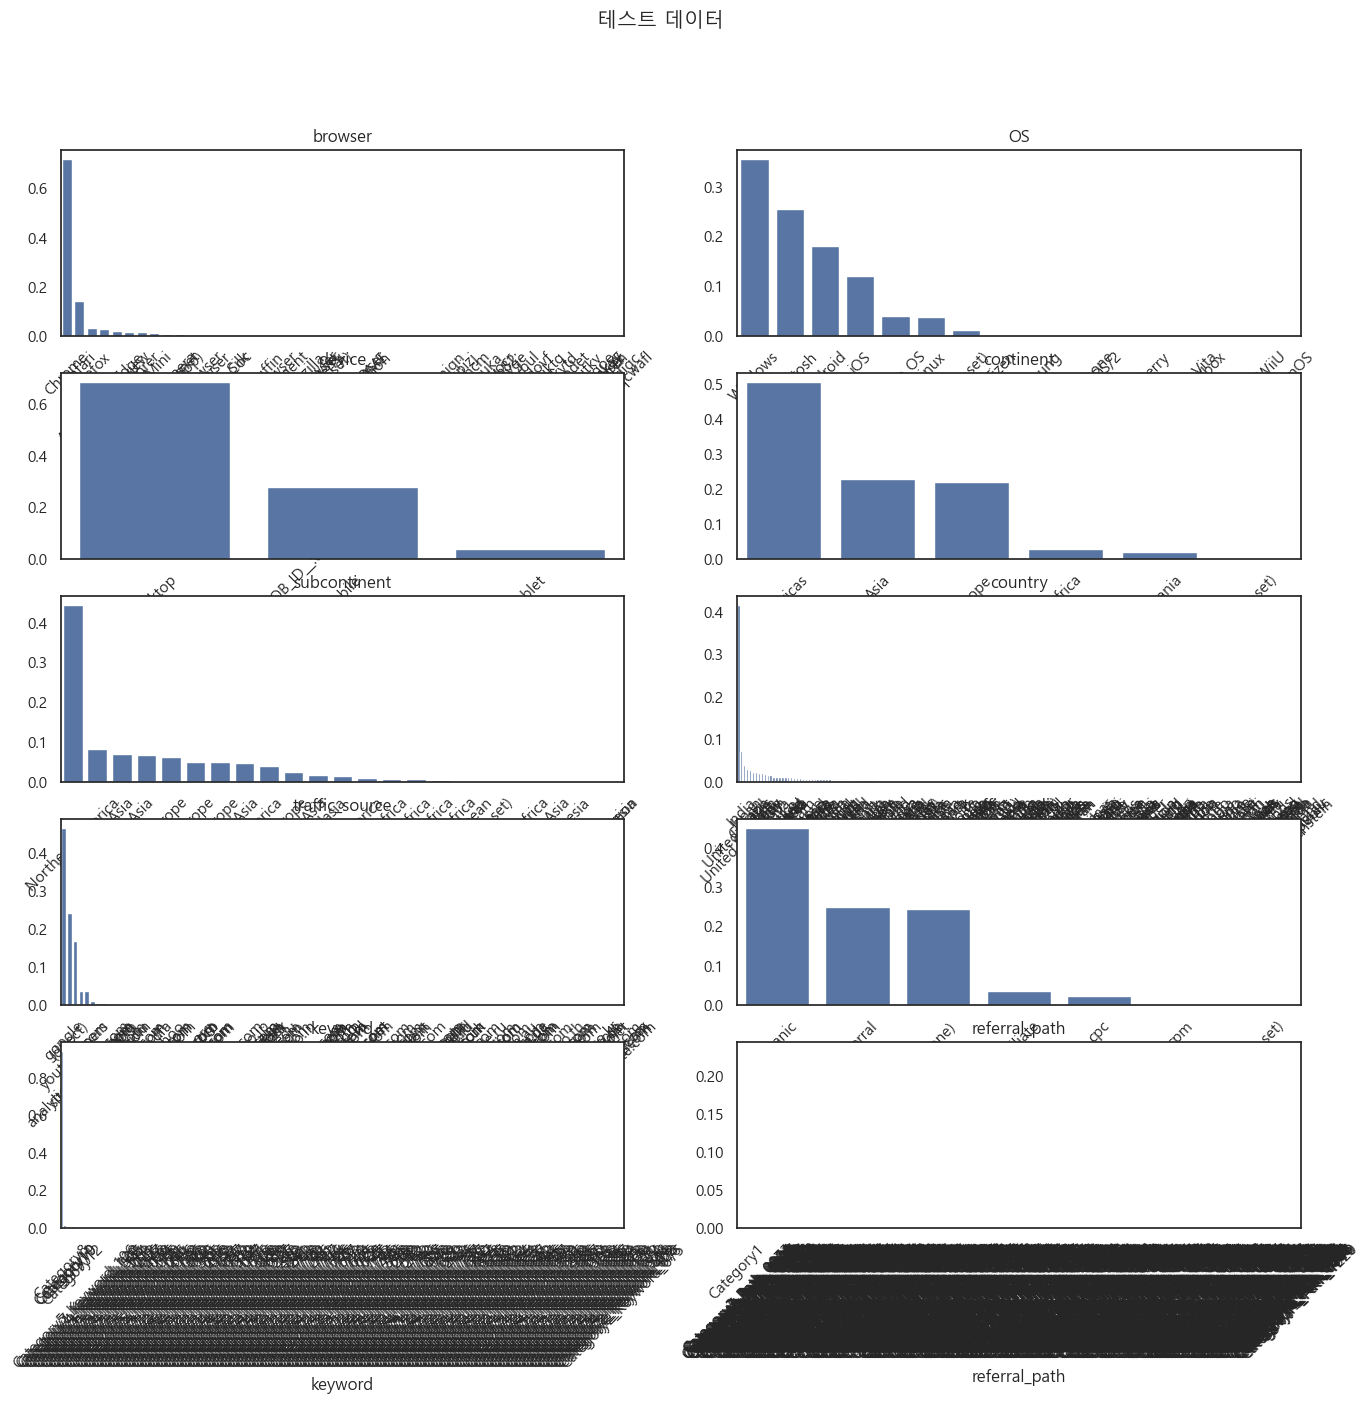

In [247]:
object_col = test.describe(include ='object').columns.tolist()[2:]
fig, axes = plt.subplots(5, 2, figsize=(16, 14))

for i, col in enumerate(object_col):  
    counts = test[col].value_counts(normalize=True).values
    categories = test[col].value_counts(normalize=True).index
    
    sns.barplot(x=categories, y=counts, ax=axes[i//2, i%2])
    axes[i//2, i%2].tick_params(axis='x', rotation=45)
    axes[i//2, i%2].set_title(col)

plt.suptitle("테스트 데이터")
plt.tight_layout()
plt.show()
# plt.savefig("./테스트 범주형_전처리X.png")

## 데이터 전처리

In [359]:
## 학습에 사용하지 않을 변수 제거
df.drop(['sessionID', 'userID', 'subcontinent', 'country'] , axis=1, inplace=True)
test.drop(['sessionID', 'userID', 'subcontinent', 'country'] , axis=1, inplace=True)

### 결측치 전처리

In [360]:
## keyword
df['keyword'].fillna("unknown",inplace=True)
test['keyword'].fillna("unknown",inplace=True)

## referral_path
df['referral_path'].fillna("unknown",inplace=True)
test['referral_path'].fillna("unknown",inplace=True)

### 데이터 스케일

#### quality
- 로그변환으로 축소

In [361]:
### Train 데이터 전처리
df['quality'] = np.log1p(df['quality'])

### Test 데이터 전처리
test['quality'] = np.log1p(test['quality'])

#### duration 
- 로그변환으로 축소

In [362]:
### Train 데이터 전처리
df['duration'] = np.log1p(df['duration'])

### Test 데이터 전처리
test['duration'] = np.log1p(test['duration'])

#### transaction_revenue 
- 로그변환으로 축소

In [363]:
### Train 데이터 전처리
df['transaction_revenue'] = np.log1p(df['transaction_revenue'])

### Test 데이터 전처리
test['transaction_revenue'] = np.log1p(test['transaction_revenue'])

### 범주형 전처리

In [364]:
def browser_cleaning(data, browser_col):
    for i in browser_col:
        data.loc[data['browser'] == i, 'browser'] = 'unknown'
    return 

In [365]:
## train, test 데이터의 범위가 같아서 진행해도 됨
bb = test['browser'].value_counts().loc[:'Puffin'].index.tolist()
aa = df['browser'].value_counts().loc[:'Puffin'].index.tolist()

if str(aa).find(str(bb)):
    pass
else:
    print(f"{aa}값이 존재하지 않음")

In [366]:
## 상위 17개 browser 이후 데이터들은 다 unknown 처리
unknown_df = df['browser'].value_counts().iloc[17:].index.tolist()
unknown_test = test['browser'].value_counts().iloc[17:].index.tolist()

In [367]:
######### browser 전처리 #########

# train data browser 전처리
browser_cleaning(df, unknown_df)
print(len(df['browser'].value_counts()))

# test data browser 전처리
browser_cleaning(test, unknown_test)
print(len(test['browser'].value_counts()))

18
18


In [368]:
def os_cleaning(data, cleaning_type):
    
    #######  방법 1 unknown 으로 전처리  #######
    #######  방법 2 (not set)으로 전처리  #######
    
    not_in_col = data[~data['OS'].isin(os_col)].index
    
    data.loc[not_in_col, 'OS'] = cleaning_type
    
    return 

In [369]:
######### os 전처리 #########

# 유명한 os 
os_col = ['Windows', 'Macintosh', 'Android', 'iOS', 'Linux', 'Chrome OS','(not set)']

# train data OS 전처리
os_cleaning(df, 'unknown')
print(df['OS'].unique())

# test data OS 전처리
os_cleaning(test, 'unknown')
print(test['OS'].unique())

['Macintosh' 'Windows' 'Android' 'iOS' 'Linux' 'unknown' 'Chrome OS'
 '(not set)']
['Linux' 'iOS' 'Windows' 'Android' 'unknown' 'Macintosh' 'Chrome OS'
 '(not set)']


- device - 전처리 없이 사용
- continent - 전처리 없이 사용 
- subcontinent - 사용 X
- country - 사용 X
- traffic_medium

In [370]:
def traffic_cleaning(data):
    data.loc[data['traffic_source'].str.contains('google'), 'traffic_source'] = 'google'
    data.loc[data['traffic_source'].str.contains('youtube'), 'traffic_source'] = 'youtube'
    data.loc[data['traffic_source'].str.contains('facebook'), 'traffic_source'] = 'facebook'
    data.loc[data['traffic_source'].str.contains('yahoo'), 'traffic_source'] = 'yahoo'
    
    traffic_col = data['traffic_source'].value_counts().index[:5] ## 상위 5개

    not_in_traffic_col = data[~data['traffic_source'].isin(traffic_col)].index
    
    data.loc[not_in_traffic_col, 'traffic_source'] = "unknown"
    
    return 

In [371]:
######### traffic_source 전처리 #########

# train data traffic_source 전처리
traffic_cleaning(df)
print(df['traffic_source'].unique())

# test data traffic_source 전처리
traffic_cleaning(test)
print(test['traffic_source'].unique())

['google' '(direct)' 'Partners' 'youtube' 'unknown' 'facebook']
['(direct)' 'google' 'youtube' 'Partners' 'unknown' 'facebook']


In [372]:
def keyword_cleaning(data):
    
    tt = data['keyword'].tolist()
    data['keyword'] = [t.split("_")[0] for t in tt]
    
    return 

In [373]:
######### keyword 전처리 #########

# train data keyword 전처리
keyword_cleaning(df)
print(df['keyword'].unique())

# test data keyword 전처리
keyword_cleaning(test)
print(test['keyword'].unique())

['Category8' 'unknown' 'Category9' 'Category1' 'Category10' 'Category6'
 'Category2' 'Category11' 'Category4' 'Category3' 'Category5' 'Category12'
 'Category7']
['unknown' 'Category8' 'Category3' 'Category10' 'Category5' 'Category9'
 'Category1' 'Category4' 'Category11' 'Category2' 'Category6' 'Category12'
 'Category7']


In [374]:
def referral_cleaning(data):
    
    tt = data['referral_path'].tolist()
    data['referral_path'] = [t.split("_")[0] for t in tt]
    
    return 

In [375]:
######### referral_path 전처리 #########

# train data referral_path 전처리
referral_cleaning(df)
print(df['referral_path'].unique())

# test data referral_path 전처리
referral_cleaning(test)
print(test['referral_path'].unique())

['unknown' 'Category6' 'Category7' 'Category5' 'Category11' 'Category8'
 'Category9' 'Category13' 'Category1' 'Category2' 'Category3' 'Category4'
 'Category12' 'Category10']
['Category1' 'unknown' 'Category2' 'Category11' 'Category3' 'Category10'
 'Category6' 'Category8' 'Category5' 'Category12' 'Category13' 'Category7'
 'Category9' 'Category4']


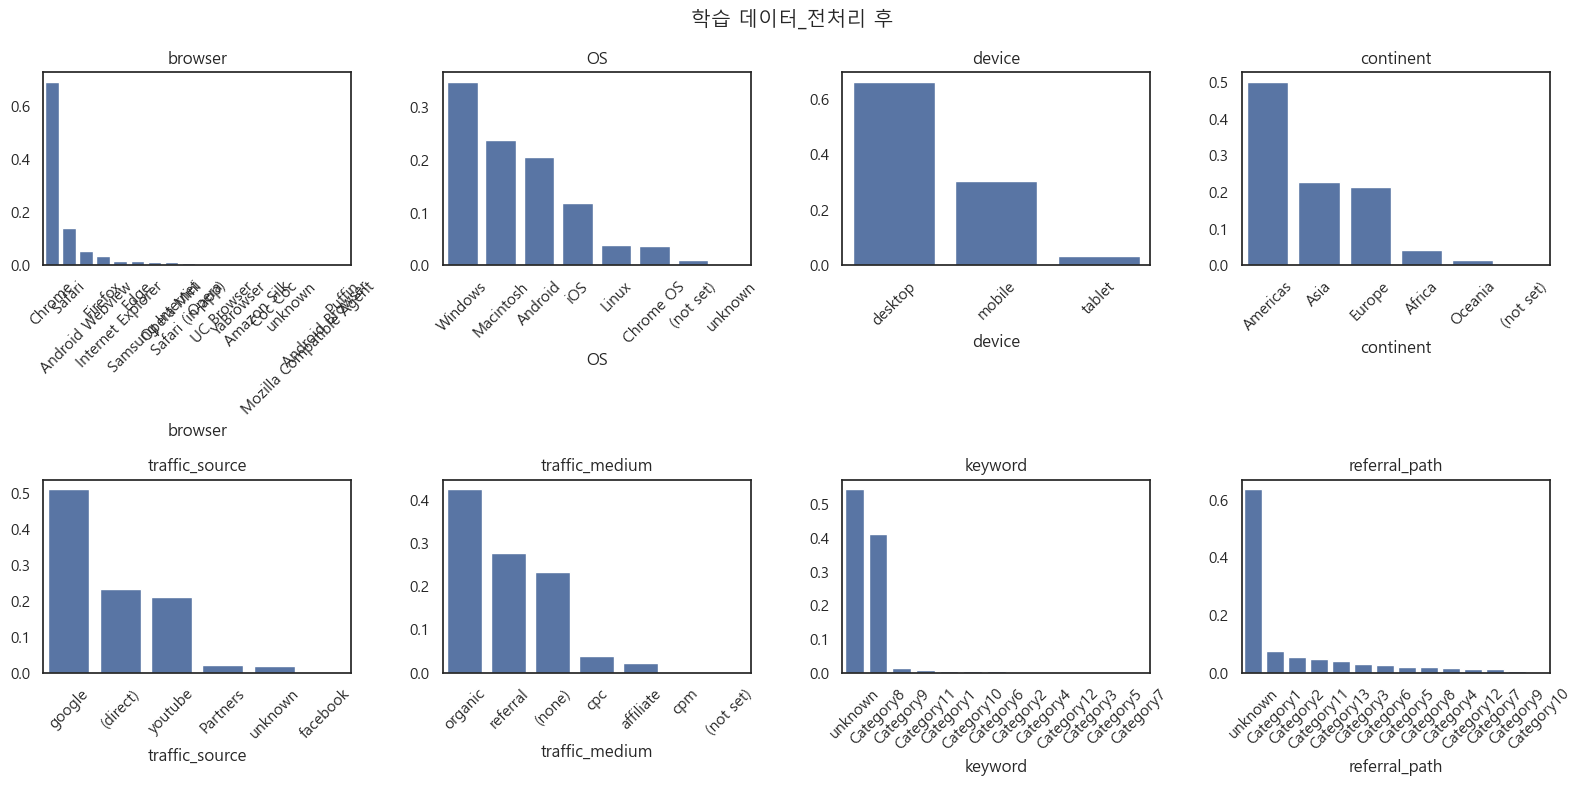

In [379]:
## 전처리한 범주형 데이터만 시각화
## 학습에 진행시킬 변수명 저장
object_col = df.describe(include ='object').columns.tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(object_col):  
    counts = df[col].value_counts(normalize=True).values
    categories = df[col].value_counts(normalize=True).index
    
    sns.barplot(x=categories, y=counts, ax=axes[i//4, i%4])
    axes[i//4, i%4].tick_params(axis='x', rotation=45) 
    axes[i//4, i%4].set_title(col)

plt.suptitle("학습 데이터_전처리 후")
plt.tight_layout()
# plt.show()
# plt.savefig("./학습 범주형_전처리 후.png")

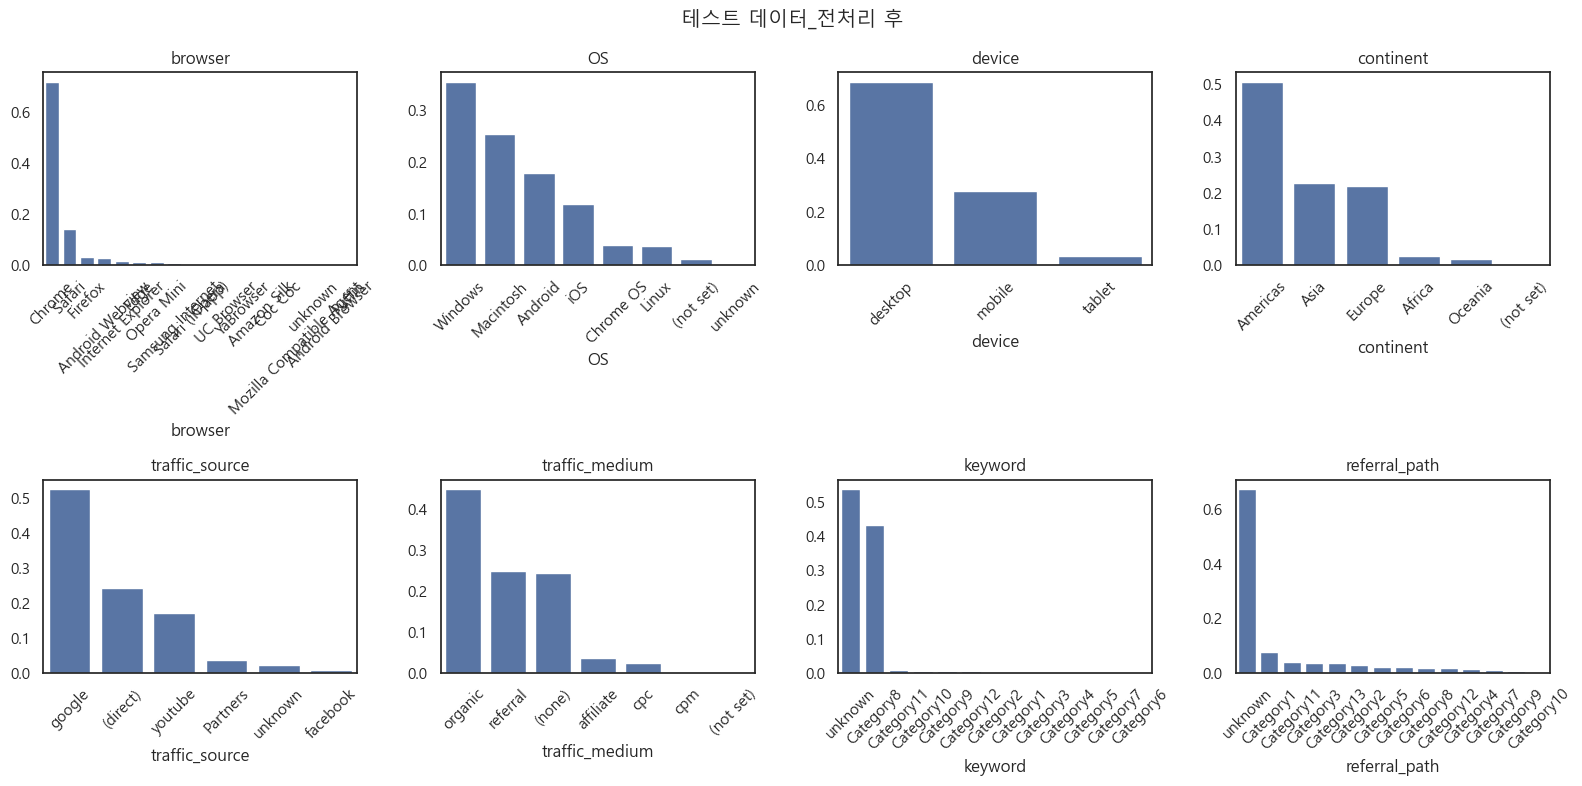

In [380]:
## 전처리한 범주형 데이터만 시각화
## 학습에 진행시킬 변수명 저장
object_col = test.describe(include ='object').columns.tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(object_col):  
    counts = test[col].value_counts(normalize=True).values
    categories = test[col].value_counts(normalize=True).index
    
    sns.barplot(x=categories, y=counts, ax=axes[i//4, i%4])
    axes[i//4, i%4].tick_params(axis='x', rotation=45) 
    axes[i//4, i%4].set_title(col)

plt.suptitle("테스트 데이터_전처리 후")
plt.tight_layout()
# plt.show()
# plt.savefig("./테스트 범주형_전처리 후.png")

### 범주형 기초통계

In [284]:
display(df.groupby('browser')['TARGET'].describe().T)

browser,Amazon Silk,Android Browser,Android Webview,Chrome,Coc Coc,Edge,Firefox,Internet Explorer,Mozilla Compatible Agent,Opera,Opera Mini,Puffin,Safari,Safari (in-app),Samsung Internet,UC Browser,YaBrowser,unknown
count,257.000000,110.000000,13855.000000,174395.000000,206.000000,3702.000000,8436.000000,4573.000000,124.000000,1331.000000,3041.000000,55.000000,35689.000000,1995.000000,3077.000000,901.000000,402.000000,140.000000
mean,2.859922,1.927273,2.328329,3.944563,3.199029,2.851162,3.137624,2.475836,2.935484,3.076634,1.990464,3.618182,3.119224,1.835088,2.403315,1.698113,3.323383,2.157143
std,3.759861,1.961600,3.406609,5.823281,5.164060,4.089151,6.590676,4.267483,4.442481,4.435688,2.136057,7.501829,4.913320,2.728683,3.649309,1.856486,5.286307,2.977787
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,3.000000,2.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,2.250000,3.000000,2.000000,3.000000,3.000000,1.000000,2.000000,2.000000,3.000000,2.000000
max,27.000000,14.000000,270.000000,283.000000,40.000000,61.000000,386.000000,113.000000,34.000000,44.000000,32.000000,46.000000,199.000000,37.000000,50.000000,18.000000,59.000000,23.000000


In [285]:
display(df.groupby('OS')['TARGET'].describe().T)

OS,(not set),Android,Chrome OS,Linux,Macintosh,Windows,iOS,unknown
count,2592.00000,51870.000000,9222.000000,9562.000000,60316.000000,88119.000000,29778.000000,830.000000
mean,2.04591,3.049875,5.186511,4.025309,4.549307,3.269590,3.099973,2.096386
std,2.33027,5.072670,6.912903,5.107667,6.169867,5.361345,4.724905,2.532369
min,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.00000,1.000000,3.000000,2.000000,2.000000,1.000000,1.000000,1.000000
75%,2.00000,3.000000,6.000000,5.000000,6.000000,3.000000,3.000000,2.000000
max,34.00000,270.000000,96.000000,74.000000,199.000000,386.000000,94.000000,31.000000


In [286]:
display(df.groupby('continent')['TARGET'].describe().T)

continent,(not set),Africa,Americas,Asia,Europe,Oceania
count,336.000000,10514.000000,126506.000000,57254.000000,53748.000000,3931.000000
mean,3.252976,2.274967,4.438208,2.760104,2.774596,3.243958
std,4.677510,2.772075,6.281257,4.474850,4.634260,4.867743
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000
75%,3.000000,3.000000,5.000000,3.000000,3.000000,3.000000
max,42.000000,118.000000,386.000000,224.000000,283.000000,72.000000


In [287]:
display(df.groupby('traffic_source')['TARGET'].describe().T)

traffic_source,(direct),Partners,facebook,google,unknown,youtube
count,59026.000000,5369.000000,747.000000,129283.000000,4988.000000,52876.000000
mean,4.580778,3.112125,3.168675,3.734706,3.153368,2.238369
std,6.661119,4.648776,4.328772,5.536609,4.461265,3.605138
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000
75%,5.000000,3.000000,3.000000,4.000000,3.000000,2.000000
max,386.000000,69.000000,40.000000,283.000000,60.000000,198.000000


In [288]:
display(df.groupby('traffic_medium')['TARGET'].describe().T)

traffic_medium,(none),(not set),affiliate,cpc,cpm,organic,referral
count,59022.000000,6.000000,5365.000000,9978.000000,501.000000,107370.000000,70047.000000
mean,4.581021,1.500000,3.113327,2.911606,3.047904,3.842656,2.514340
std,6.661280,0.547723,4.650281,4.929838,4.424670,5.621129,4.010136
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,1.500000,1.000000,1.000000,1.000000,2.000000,1.000000
75%,5.000000,2.000000,3.000000,2.000000,3.000000,4.000000,3.000000
max,386.000000,2.000000,69.000000,79.000000,34.000000,283.000000,198.000000


In [289]:
display(df.groupby('keyword')['TARGET'].describe().T)

keyword,Category1,Category10,Category11,Category12,Category2,Category3,Category4,Category5,Category6,Category7,Category8,Category9,unknown
count,1318.000000,1147.000000,1931.000000,398.000000,769.000000,298.000000,402.000000,94.000000,1121.000000,64.000000,103584.00000,3488.000000,137675.000000
mean,5.476480,1.625981,3.144485,1.291457,2.771131,5.224832,2.676617,4.276596,5.694915,1.140625,3.85797,1.263761,3.450561
std,7.121293,1.829215,5.612749,0.815762,3.633202,6.822901,3.536049,6.158139,6.980308,0.587359,5.63256,1.267418,5.456975
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
50%,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,3.000000,1.000000,2.00000,1.000000,2.000000
75%,7.000000,1.000000,3.000000,1.000000,3.000000,6.750000,3.000000,4.000000,7.000000,1.000000,4.00000,1.000000,4.000000
max,73.000000,27.000000,79.000000,7.000000,36.000000,53.000000,31.000000,44.000000,57.000000,5.000000,283.00000,22.000000,386.000000


In [290]:
display(df.groupby('referral_path')['TARGET'].describe().T)

referral_path,Category1,Category10,Category11,Category12,Category13,Category2,Category3,Category4,Category5,Category6,Category7,Category8,Category9,unknown
count,18687.000000,733.000000,12165.000000,3452.000000,9775.000000,13682.000000,7751.000000,3766.000000,5268.000000,6918.000000,3023.000000,4584.000000,1378.000000,161107.000000
mean,6.501258,4.480218,2.398438,3.557648,1.940051,2.108537,3.012902,1.973447,2.161352,3.900116,2.479656,2.785777,4.447750,3.704302
std,7.443151,4.722774,3.853126,3.781006,3.024233,2.588452,4.704215,2.831494,4.350481,4.512268,3.465367,5.385745,8.174776,5.695184
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,4.000000,3.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000
75%,8.000000,6.000000,2.000000,5.000000,2.000000,3.000000,3.000000,2.000000,2.000000,5.000000,3.000000,2.000000,4.000000,4.000000
max,161.000000,49.000000,115.000000,52.000000,95.000000,198.000000,101.000000,66.000000,141.000000,70.000000,61.000000,125.000000,152.000000,386.000000


#### 범주형 인코딩

In [187]:
#### 더미 변수로 전처리할 데이터
object_train = df[object_col] 
object_test = test[object_col]

object_train.head()

,browser,OS,device,continent,traffic_source,traffic_medium,keyword,referral_path
0,Chrome,Macintosh,desktop,Americas,google,organic,Category8,unknown
1,Chrome,Windows,desktop,Europe,google,organic,Category8,unknown
2,Samsung Internet,Android,mobile,Asia,(direct),(none),unknown,unknown
3,Chrome,Macintosh,desktop,Americas,Partners,affiliate,unknown,unknown
4,Chrome,iOS,mobile,Americas,google,referral,unknown,Category6


#### 더미 변수

In [218]:
## 차원을 더 축소하기 위해서 , drop_first=True 옵션 적용 
dum_train = pd.get_dummies(df, drop_first=True)
dum_test = pd.get_dummies(test, drop_first=True)

dum_train

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue,browser_Android Browser,browser_Android Webview,browser_Chrome,...,referral_path_Category13,referral_path_Category2,referral_path_Category3,referral_path_Category4,referral_path_Category5,referral_path_Category6,referral_path_Category7,referral_path_Category8,referral_path_Category9,referral_path_unknown
0,17.0,0,3.828641,6.733402,0,0.0,0.0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,3.0,1,0.693147,3.688879,0,0.0,0.0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,1.0,1,0.693147,0.000000,1,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1.0,1,0.693147,0.000000,1,0.0,0.0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,1.0,0,0.693147,0.000000,1,0.0,0.0,False,False,True,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252284,1.0,1,0.693147,0.000000,1,0.0,0.0,False,False,True,...,False,False,False,False,True,False,False,False,False,False
252285,1.0,0,0.693147,0.000000,1,0.0,0.0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
252286,5.0,0,1.098612,4.248495,0,0.0,0.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
252287,1.0,1,0.693147,3.367296,0,0.0,0.0,False,True,False,...,False,True,False,False,False,False,False,False,False,False


In [296]:
np.sum(dum_train.isnull().sum())
np.sum(dum_test.isnull().sum())

0

#### One Hot Encoding

In [46]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoder 객체 생성
encoder = OneHotEncoder()

In [47]:
# One-Hot Encoding 수행
encoded_categories_train = encoder.fit_transform(object_train)

encoded_categories_test = encoder.transform(object_test)

# 희소 행렬인 One-Hot Encoding 결과를 데이터 프레임으로 변환
encoded_train = pd.DataFrame(encoded_categories_train.toarray(), columns=encoder.get_feature_names_out(object_train.columns))

encoded_test = pd.DataFrame(encoded_categories_test.toarray(), columns=encoder.get_feature_names_out(object_test.columns))

# 변환된 결과 출력
# encoded_train

#### Binary Encoding

In [53]:
import category_encoders as ce

categorical_columns = object_train.columns ## train, test 모두 같음

encoder = ce.BinaryEncoder(cols=categorical_columns)

bin_train = encoder.fit_transform(df[categorical_columns])

bin_test = encoder.transform(test[categorical_columns])

### 범주형 변수 상관계수

In [199]:
from scipy.stats.contingency import association
from scipy.stats import chi2_contingency

def corr_cramer(x):
    new_tab = pd.crosstab(df['TARGET'], df[x])
    result = association(new_tab, method="cramer")
    return result

In [200]:
for col in object_col:
    print(col, "상관계수:", np.round(corr_cramer(col), 5))

browser 상관계수: 0.05258
OS 상관계수: 0.07669
device 상관계수: 0.08354
continent 상관계수: 0.11039
traffic_source 상관계수: 0.09265
traffic_medium 상관계수: 0.08423
keyword 상관계수: 0.0423
referral_path 상관계수: 0.08409


In [349]:
## 학습 데이터와 테스트 데이터 모두 같다
int_col = ['TARGET', 'new', 'bounced', 'quality', 'duration', 'transaction', 'transaction_revenue']
new_data = df[int_col]

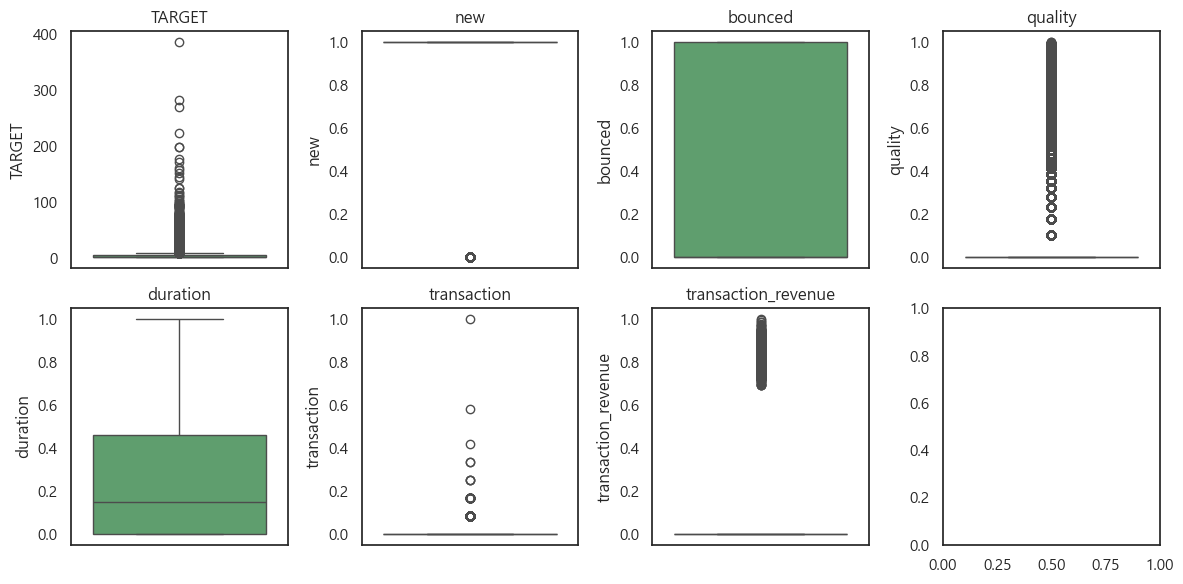

In [350]:
num_cols = new_data.columns.tolist()
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

## 박스플롯
for idx, col in enumerate(num_cols):
    sns.boxplot(y=new_data[col], ax=axes[idx//4, idx%4], color='g') 
    axes[idx//4, idx%4].set_title(col)
 
plt.tight_layout()
plt.show()

### 다중공선성 확인

               feature        VIF
0                  new   3.712329
1              quality   5.273707
2             duration   6.118292
3              bounced   3.824303
4          transaction  10.764037
5  transaction_revenue  10.936611


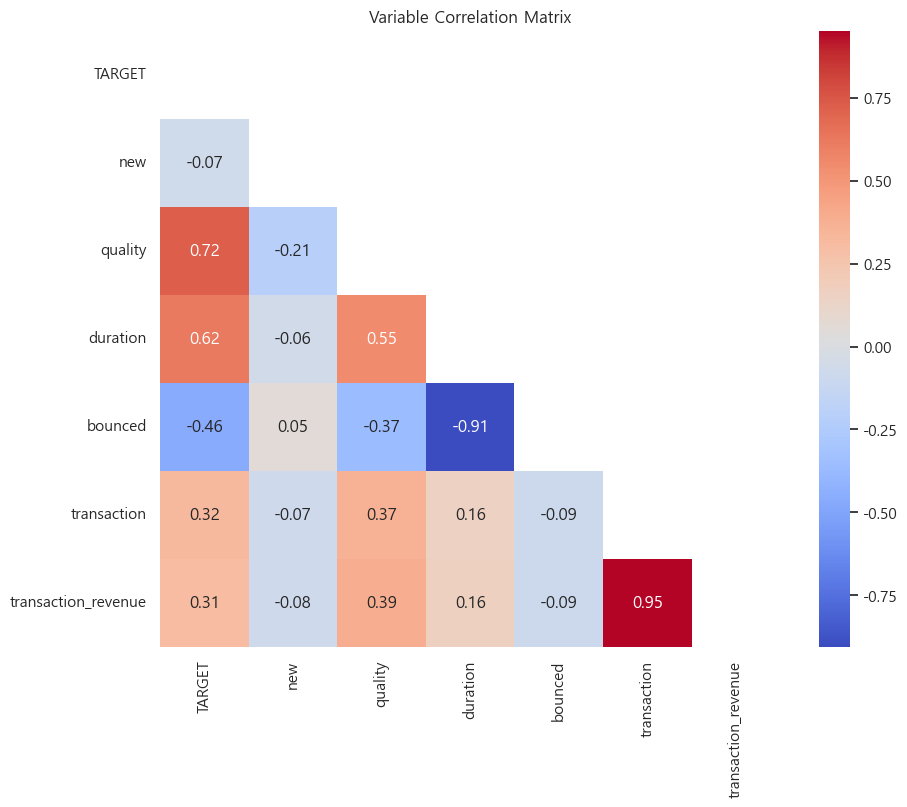

In [216]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 연속형만 추출
numeric_df = df.select_dtypes(exclude=['object','category'])

## 상관계수
correlation_matrix = numeric_df.corr()

## 대칭 결과이기 때문에 위쪽 부분 mask
mask = np.triu(np.ones_like(correlation_matrix))

selected_columns = numeric_df.columns.tolist()[1:]

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = selected_columns
vif_data["VIF"] = [variance_inflation_factor(df[selected_columns].values, i) for i in range(len(selected_columns))]

# VIF 출력
print(vif_data)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap = 'coolwarm', mask = mask)
plt.title('Variable Correlation Matrix')
plt.show()

## 데이터 분리 - Hold_out

In [220]:
## 데이터 분할
X = dum_train.drop('TARGET',axis=1)
Y = dum_train.TARGET

In [221]:
from sklearn.model_selection import train_test_split

## 학습용 데이터 생성
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

## 모델 파트

### RandomForestRegressor 모델 생성

In [222]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import time
from sklearn.metrics import make_scorer, mean_squared_error

### 랜덤 서치

In [78]:
# 모델 생성
rf_model = RandomForestRegressor(n_jobs=-1, random_state=1106)

# 하이퍼파라미터 튜닝
param_space = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [2, 3, 4, 5, 6]
}

In [79]:
# RMSE를 평가 지표로 사용하는 함수 정의
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# RMSE를 평가 지표로 사용하기 위해 함수를 scorer로 변환
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(rf_model, param_distributions=param_space, n_iter=50, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, scoring=rmse_scorer)

# 랜덤 서치 수행 전 현재 시간 기록
start_time = time.time()

# 랜덤 서치 수행
random_search.fit(x_train, y_train)

# 랜덤 서치 수행 후 현재 시간 기록
end_time = time.time()

# 수행 시간 계산
elapsed_time = end_time - start_time

# 최적의 하이퍼파라미터
best_params = random_search.best_params_

# 최적의 하이퍼파라미터와 평가 점수 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)
print("최고의 평가 점수:", np.abs(random_search.best_score_))
print("랜덤 서치 수행 시간:", elapsed_time/60, "분")

최적의 하이퍼파라미터: {'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_depth': None}
최고의 평가 점수 (음수로 출력됨): 3.0089711325791173
랜덤 서치 수행 시간: 15.79423957268397 분


#### 모델 학습

In [80]:
# 랜덤포레스트 학습 + 랜덤 서치 + 범주까지 포함
rf_optimal_model = RandomForestRegressor(random_state=0, **best_params)
rf_optimal_model.fit(x_train, y_train)

RandomForestRegressor(min_samples_leaf=6, min_samples_split=6, n_estimators=400,
                      random_state=0)

#### 모델 성능 평가

In [100]:
################# 랜덤 결과
# 훈련 세트의 예측값 계산
y_train_pred = rf_optimal_model.predict(x_train)

# 검증 세트의 예측값 계산
y_valid_pred = rf_optimal_model.predict(x_valid)

# RMSE 계산
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

print("훈련 세트 RMSE: {:.2f}".format(train_rmse))
print("검증 세트 RMSE: {:.2f}".format(valid_rmse))

훈련 세트 RMSE: 2.72
검증 세트 RMSE: 2.74


In [103]:
from sklearn.metrics import r2_score

R2_train = r2_score(y_train, y_train_pred) # R2
R2_valid = r2_score(y_valid, y_valid_pred) # R2


print("훈련 세트 R2: {:.3f}".format(R2_train))
print("검증 세트 R2: {:.3f}".format(R2_valid))

훈련 세트 R2: 0.758
검증 세트 R2: 0.741


#### Submission

In [ ]:
preds = rf_optimal_model.predict(dum_test)
preds[preds < 0] = 0 ## 0보다 작은 값은 0으로 수정

In [ ]:
submission = pd.read_csv('./Weblog_Data/sample_submission.csv')
submission['TARGET'] = preds
submission

In [ ]:
# submission.to_csv('./0220_1_submission.csv', index=False)

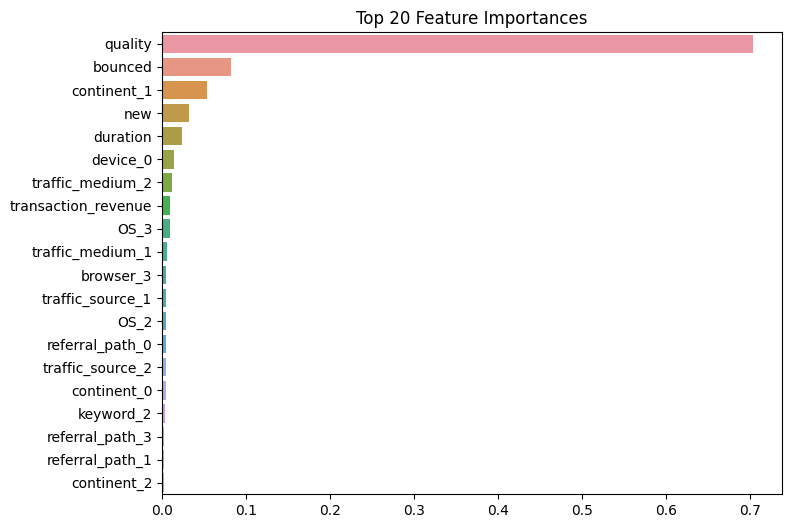

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_optimal_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()